# Connect Intensive - Machine Learning Nanodegree

## Week 6. Clustering Miniproject

### Objectives    

  - Perform k-means clustering on the Enron Data Set.  
  - Visualize different clusters that form before and after feature scaling.  
  - Plot decision boundaries that arise from k-means clustering using two features.   
  
### Prerequisites
  - [matplotlib](http://matplotlib.org/index.html)  
  - [numpy](http://www.scipy.org/scipylib/download.html)  
  - [pandas](http://pandas.pydata.org/getpandas.html)  
  - [sklearn](http://scikit-learn.org/stable/install.html)  

---

## 1 | Get Data

In [3]:
# import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display
import pickle

We are going to use the Enron datasets. Here is more information about the [Enron scandal](https://en.wikipedia.org/wiki/Enron_scandal). The datasets can be found in the [ud120-projects repo](https://github.com/udacity/ud120-projects) on GitHub. The datasets are in **pickled** form. 

### `pickle`

Suppose you're working with Python and you assemble nice data structures (*e.g.* dictionaries, lists, tuples, sets...) that you'll want to re-use in Python at a later time. [The `pickle` module](https://docs.python.org/2/library/pickle.html) is a fast, efficient way to preserve (or pickle) those data structures without you needing to worry about how to structure or organize your output file. One nice thing about using `pickle` is that the data structures you store can be arbitrarily complex: you can have nested data structures (*e.g.* lists of tuples as the values in a dictionary) and `pickle` will know exactly how to serialize (or write) those structures to file. The next time you're in Python, you can un-pickle the data structures using `pickle.load()` and pick up right where you left off.

> Reference on `pickle`: [Serializing Python Objects](http://www.diveintopython3.net/serializing.html).

In [4]:
# load data
pickle_file = open('./data/dataset.pkl', 'rb')
enron_data = pickle.load(pickle_file)
pickle_file.close()
print 'Enron data loaded successfully!'

Enron data loaded successfully!


## 2 | Data Preprocessing  

We couldn't find *all* the information for each person involved with the Enron scandal, so the Enron dataset has some missing values denoted by `"NaN"` in the data dictionary. Because we must pass numeric arrays into `sklearn`, we need to preprocess the data dictionary a bit before we can use [`sklearn.cluster.KMeans()`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

**Run** the cell below to complete our preprocessing steps:
  - Remove the outlier: there is an entry `"TOTAL"` in the data dictionary containing totals of all features.
  - Create a pandas `DataFrame` object from the Enron data dictionary
  - Take the **transpose** of the Enron `DataFrame` with [`DataFrame.T`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.T.html), so that rows correspond to individuals (instances). Recall that we used [`stack()` and `unstack()`](http://pandas.pydata.org/pandas-docs/stable/reshaping.html#reshaping-by-stacking-and-unstacking) last time to accomplish this task... but taking the transpose is more straightforward.
  - Impute missing values: Replace all "NaN" values in the DataFrame with **zeroes**.

In [21]:
# Preprocessing the Enron dataset:
# there's an outlier--remove it! 
enron_data.pop('TOTAL', 0)

# Create a DataFrame object from the Enron data dictionary
enron_df = pd.DataFrame.from_dict(enron_data)

# Take the transpose (.T) of the Enron DataFrame,
# so that rows of the DataFrame correspond to individuals
enron_df = enron_df.T

# Change all entries in the DataFrame with "NaN" to zeroes.
enron_df[enron_df == 'NaN'] = 0

# Display the DataFrame after preprocessing is complete
display(enron_df.head())

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
ALLEN PHILLIP K,4175000,2869717,-3081055,0,phillip.allen@enron.com,1729541,13868,2195,47,65,...,304805,152,False,126027,-126027,201955,1407,2902,4484442,1729541
BADUM JAMES P,0,178980,0,0,0,257817,3486,0,0,0,...,0,0,False,0,0,0,0,0,182466,257817
BANNANTINE JAMES M,0,0,-5104,0,james.bannantine@enron.com,4046157,56301,29,39,0,...,0,864523,False,1757552,-560222,477,465,566,916197,5243487
BAXTER JOHN C,1200000,1295738,-1386055,0,0,6680544,11200,0,0,0,...,1586055,2660303,False,3942714,0,267102,0,0,5634343,10623258
BAY FRANKLIN R,400000,260455,-201641,0,frank.bay@enron.com,0,129142,0,0,0,...,0,69,False,145796,-82782,239671,0,0,827696,63014


## 3 | K-Means Clustering

In this mini-project, you will perform [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) on the Enron dataset. We're going to define a function `DrawClusters()` that will allow us to visualize the resulting clusters. 

**Read** the cell below to get an idea of what happens in the `DrawClusters()` function. 

In [34]:
from sklearn.cluster import KMeans

def DrawClusters(n_clusters = 2,\
                 feature_list = ['salary', 'exercised_stock_options'],\
                 remove_any_zeroes = False,\
                 remove_all_zeroes = True,\
                 rescale_features = False,\
                 x_label = 'Salary',\
                 y_label = 'Exercised Stock Options'):
    
    '''
    Plots k-means clusters trained on a list of features from enron_df
    @param n_clusters:        an integer, the number of clusters to form.
    @param feature_list:      a list of strings, the features to use in KMeans clustering
                              (first two features in the list will be plotted on x,y axes)
                              if len(feature_list) == 2, decision boundaries will be plotted 
    @param remove_any_zeroes: a boolean, whether or not to remove points when clustering
                              that contain ANY zeroes
    @param remove_all_zeroes: a boolean, whether or not to remove points when clustering
                              that contain ONLY zeroes
    @param rescale_features:  a boolean, whether or not to rescale features from 0 to 1
    @param x_label:           a string, the x-axis label of the plot
    @param y_label:           a string, the y-axis label of the plot
    '''

    # Initialize color and shape lists for scatterplot
    # Note: need to lengthen the color and shape lists if
    #       you want to use more than 7 clusters.
    color_list = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    shape_list = ['^', 'o', 's', 'v', 'D', '<', 'h']
    
    # Initialize figure and axes:
    fig, ax = plt.subplots(figsize=(8, 6))

    # We are going to cluster the data using KMeans,
    # based on the features from the parameter feature_list.
    X = enron_df[feature_list]
    
    # We can see if clustering correctly identified POIs
    y = enron_df['poi']
    
    # If desired, remove instances where ANY feature is zero
    if remove_any_zeroes:
        X = X[~(X.T == 0).any()]
        
    # If desired, remove instances where ALL features are zeroes
    if remove_all_zeroes:
        X = X[~(X.T == 0).all()]

    # If desired, rescale features
    if rescale_features:
        for feature in X.columns:
            min_feature = X[~(X[feature] == 0)][feature].min()
            max_feature = X[~(X[feature] == 0)][feature].max()
            range_feature = max_feature - min_feature
            X[feature] = (X[feature] - min_feature)*1.0 / range_feature
            
    # If we removed any instances above, we need to keep 
    # only the corresponding instances in y (the POI Series)
    y = y.loc[X.index]
    
    # By default, the first two features in the list are chosen
    # as the x and y features.
    x_feature = feature_list[0]
    y_feature = feature_list[1]

    # Determine the min & max values of x_feature, compute the range,
    # and pad the minimum and maximum x values by 5% of the range
    x_min, x_max = X[x_feature].min(), X[x_feature].max()
    x_range = x_max - x_min
    x_min -= x_range * 0.05
    x_max += x_range * 0.05
    
    # Determine the min & max values of y_feature, compute the range,
    # and pad the minimum and maximum y values by 5% of the range
    y_min, y_max = X[y_feature].min(), X[y_feature].max()
    y_range = y_max - y_min
    y_min -= y_range * 0.05
    y_max += y_range * 0.05
    
    # Compute k-means clustering.
    kmns = KMeans(n_clusters = n_clusters).fit(X)

    
    # We can visualize the decision boundaries if the 
    # k-means clusters are formed from just two features
    if len(feature_list) == 2:
        # Return coordinate matrices xx and yy from arrays
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, num = 500),\
                             np.linspace(y_min, y_max, num = 500))

        # Use the clustering to make a prediction for each point
        # in the coordinate matrices, then reshape for plotting.
        Z = kmns.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # Plot semitransparent filled contours for the
        # cluster decision boundaries
        ax.contourf(xx, yy, Z,\
                    levels=list(np.arange(n_clusters+1)-0.5),\
                    colors=tuple(color_list[:n_clusters]),alpha=0.2)
    
    # Scatterplot all of the points in each cluster,
    # with each cluster a different color and shape
    pred = kmns.predict(X)
    for cluster_idx in range(n_clusters):
        X_cluster = X[pred == cluster_idx]
        ax.scatter(X_cluster[x_feature], X_cluster[y_feature],\
                   s=30, marker = shape_list[cluster_idx],\
                   edgecolor='k', facecolor=color_list[cluster_idx], alpha=0.8)
        
    # Denote the centroids of each cluster with a white X
    centers = kmns.cluster_centers_
    if len(feature_list) == 2:
        for center in centers:
            ax.scatter(center[0],center[1],marker='x',facecolor='w',linewidth=3,s=50)
            
    # Set the title and axes labels, and adjust the aspect ratio for rescaled data
    if rescale_features:
        title   = ax.set_title('K Means - {} Clusters (Rescaled)'.format(n_clusters))
        # Force the axes aspect ratio to be plotted equally
        ax.set(adjustable='box-forced', aspect='equal')
    else:
        title   = ax.set_title('K Means - {} Clusters'.format(n_clusters))
    x_label = ax.set_xlabel(x_label)
    y_label = ax.set_ylabel(y_label)
    
    # Set the x- and y-axis limits using the padded minimum and maximum values
    xlim = ax.set_xlim((x_min,x_max))
    ylim = ax.set_ylim((y_min,y_max))
    
print 'DrawClusters() is ready to use!'

DrawClusters() is ready to use!


## 4 | Exercise

### Quiz 1: Clustering Features 

**Create** a scatterplot of the data (`Salary` vs `Exercised Stock Option`), then look at the resulting figure. What clusters you would expect to arise from this data if 2 clusters are created? That is, how would you partition the data into two clusters?

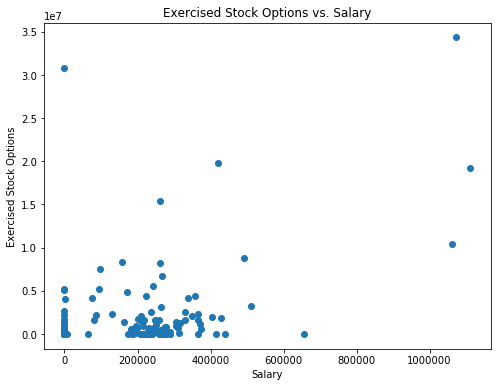

In [35]:
# TODO: create a scatter plot with 'Salary' on x-axis and 'Exercised Stock Option' on y-axis
fig = plt.figure(figsize=(8, 6))
plt.scatter(enron_df['salary'], enron_df['exercised_stock_options'])
plt.title('Exercised Stock Options vs. Salary')
plt.xlabel('Salary')
plt.ylabel('Exercised Stock Options')

### Quiz 2: Deploying Clustering 

**Run** the cell below, which will perform k-means clustering on the data using only the `salary` and `exercised_stock_options` features. Look at the resulting clusters -- because we're only using two features, we can also plot the decision boundary.

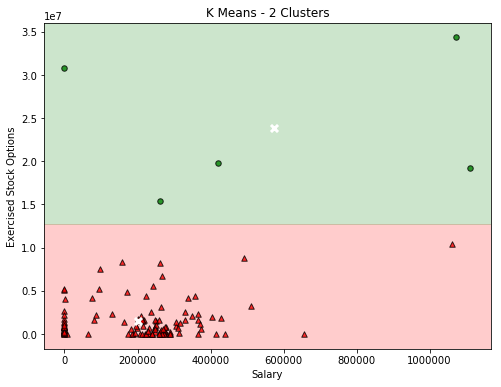

In [36]:
DrawClusters(n_clusters = 2,\
             feature_list = ["salary","exercised_stock_options"],\
             remove_any_zeroes = False,\
             remove_all_zeroes = True,\
             rescale_features = False,\
             x_label = 'Salary',\
             y_label = 'Exercised Stock Options')

### Quiz 3: Clustering with 3 Features

**Run** the cell below to add a third feature to features_list, `total_payments`. The clustering is now performed using 3 input features instead of 2 (obviously we can still only visualize the original 2 features, `salary` and `exercised_stock_options`). We also can't visualize the decision boundary anymore, because the points all have different values for the `total_payments` feature. Compare the clusterings to those you obtained with 2 input features. Do any points switch clusters? How many? This new clustering, using 3 features, couldn’t have been guessed by eye -- it was the k-means algorithm that identified it.

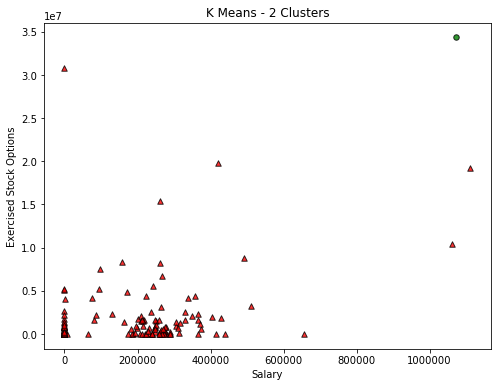

In [37]:
DrawClusters(n_clusters = 2,\
             feature_list = ["salary","exercised_stock_options","total_payments"],\
             remove_any_zeroes = False,\
             remove_all_zeroes = True,\
             rescale_features = False,\
             x_label = 'Salary',\
             y_label = 'Exercised Stock Options')

### Quiz 4: Stock Option Range

We're going to cover [feature scaling](http://sebastianraschka.com/Articles/2014_about_feature_scaling.html), a type of preprocessing that you should perform before some classification and regression tasks. Here’s a general outline of what feature scaling does.

What are the **maximum** and **minimum** values taken by the `exercised_stock_options` feature used in this example? 

In one of the preprocessing steps, all `NaN` entries in `enron_df` were changed to zeroes. We do this because all features passed into `sklearn` classifiers must be numeric. So, to answer this question, you may want to look at the original data *before* this preprocessing step was performed. To help with this task, **create** the data frame `df` from the `enron_data` dictionary without imputating the missing value.

In [38]:
# TODO: create a dataframe from Enron data dictionary without imputing the missing value

df = pd.DataFrame.from_dict(enron_data)
# Take the transpose of the DataFrame so that rows of correspond to individuals
df = df.T
df[df == 'NaN'] = np.nan

print 'DataFrame df has been created!'

DataFrame df has been created!


In [39]:
# TODO: find out the maximum and minimum values taken by the exercised_stock_options

print 'maximum values taken by exercised_stock_options {}'.format(df['exercised_stock_options'].max())
print 'minimum values taken by exercised_stock_options {}'.format(df['exercised_stock_options'].min())

maximum values taken by exercised_stock_options 34348384
minimum values taken by exercised_stock_options 3285


### Quiz 5: Salary Range

What are the **maximum** and **minimum** values taken by the `salary` feature used in this example? 

In [40]:
# TODO: find out the maximum and minimum values taken by the salary

print 'maximum values taken by salary {}'.format(df['salary'].max())
print 'minimum values taken by salary {}'.format(df['salary'].min())

maximum values taken by salary 1111258
minimum values taken by salary 477


### Quiz 6: Clustering Changes

**Run** the cell below to plot the original two clusters, with the features `salary` and `exercised_stock_options`. Note that the features are not yet scaled.

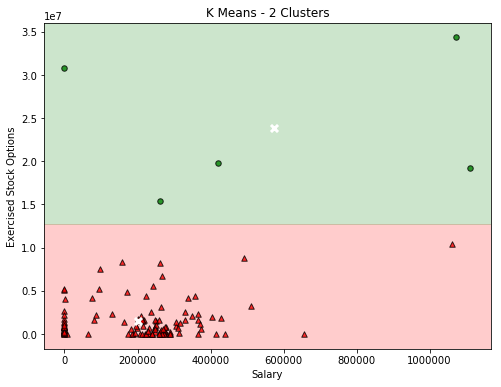

In [41]:
DrawClusters(n_clusters = 2,\
             feature_list = ['salary', 'exercised_stock_options'],\
             remove_any_zeroes = False,\
             remove_all_zeroes = True,\
             rescale_features = False,\
             x_label = 'Salary',\
             y_label = 'Exercised Stock Options')

Now **run** the cell below to do simple feature rescaling, mapping the original ranges of `exercised_stock_options` and `salary` onto the interval [0, 1]. You should find that some of the points change clusters! You should also find that these clusters are not as stable as in the previous examples. **Run** the cell multiple times. You should find that the reported clusters are sometimes different, depending on where the centroids were initialized for k-means.

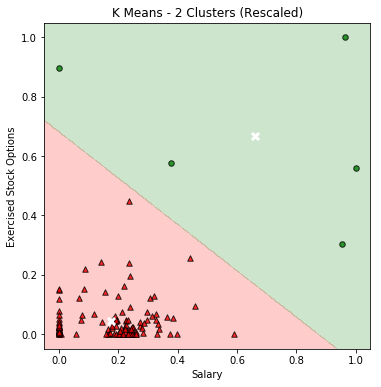

In [42]:
DrawClusters(n_clusters = 2,\
             feature_list = ['salary', 'exercised_stock_options'],\
             remove_any_zeroes = False,\
             remove_all_zeroes = True,\
             rescale_features = True,\
             x_label = 'Salary',\
             y_label = 'Exercised Stock Options')

### Quiz 7: Further Exploration

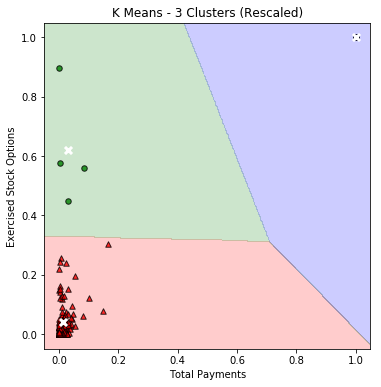

In [43]:
# Example of k-means clustering with 3 clusters, different features, rescaled
DrawClusters(n_clusters = 3,\
             feature_list = ['total_payments', 'exercised_stock_options'],\
             remove_any_zeroes = False,\
             remove_all_zeroes = True,\
             rescale_features = True,\
             x_label = 'Total Payments',\
             y_label = 'Exercised Stock Options')

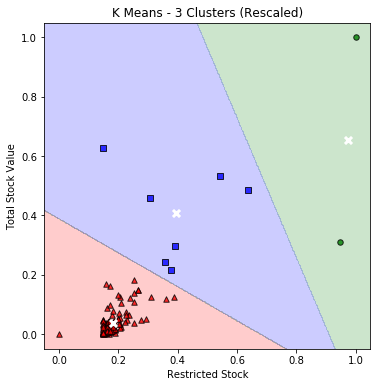

In [44]:
# Example of k-means clustering with 3 clusters, different features, rescaled
DrawClusters(n_clusters = 3,\
             feature_list = ['restricted_stock', 'total_stock_value'],\
             remove_any_zeroes = False,\
             remove_all_zeroes = True,\
             rescale_features = True,\
             x_label = 'Restricted Stock',\
             y_label = 'Total Stock Value')

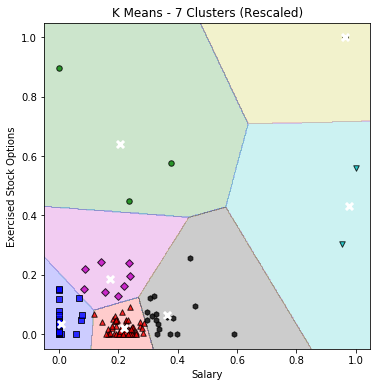

In [16]:
# Example of k-means clustering with 7 clusters, rescaled

DrawClusters(n_clusters = 7,\
             feature_list = ['salary', 'exercised_stock_options'],\
             remove_any_zeroes = False,\
             remove_all_zeroes = True,\
             rescale_features = True,\
             x_label = 'Salary',\
             y_label = 'Exercised Stock Options')